# Harmonic signal spectrum

## The purpose of work

It is necessary to obtain graphs of a square signal (single polar meander) with frequencies of 1,2,4,8 hertz and the spectra of these signals.

## Imports of necessary libraries

In [71]:
%matplotlib notebook
from numpy import sin, cos, linspace
from scipy.fft import rfft, rfftfreq, irfft, fft
from scipy.signal import square
from math import *
import matplotlib.pyplot as plt

## Core functions

In [72]:
# Static global variables to work with the signa
TIME_RANGE = 64  # Time range (sec)
FS         = 200 # Sampling freq (Hz)

def t_step(w):
    """
    Generates a time steps array
    """
    N         = FS * TIME_RANGE
    TIME_STEP = 1 / FS # Sample time interval
    return linspace(0, TIME_RANGE, N)

def f_step(w):
    """
    Generates a frequency steps array
    """
    N         = FS * TIME_RANGE
    FREQ_STEP = FS / N # Sample freq interval
    return linspace(0, TIME_RANGE, N)

def signal(_func_):
    """
    Decorator function for restoring signal from mathematical function
    """
    def wrapper(A, k, t, w, q):
        t      = t_step(w)
        f      = [_func_(A, k, ti, w, q) for ti in t]
        return (t, f) 
    return wrapper

def spectrum(__func__):
    """
    Function realizing spectrum of signal
    """
    
    N = FS * TIME_RANGE
    
    freq = rfftfreq(N, 1 / FS)
    ampl = rfft(__func__)
     
    ampl = normalize(ampl) # Normalize complex spectrum
    return freq, ampl

def normalize(fft):
    """
    Function realizing normalizing of fft spectrum
    """
    return abs(fft) / TIME_RANGE / (FS / 2)

def restore_decay(x, A, k, a=0):
    """
    Additive fade-restore function
    """
    y = [dump(xi, A, k) + a for xi in x]
    return (y, [-yi for yi in y])

def dump(t, A, k=0):
    """
    Additive function to compute dumping function amplitude
    """
    return A * exp(-k * t)



## Additive functions for plotting image

In [73]:
def ylabel(axes, label):
    """
    Method for setting y label to subplots
    """
    for axis in axes:
        axis.set_ylabel(label)

def xlabel(axes, label):
    """
    Method for setting x label to subplots
    """
    for axis in axes:
        axis.set_xlabel(label)
        
def grid(axes):
    """
    Method for drawing grid on subplots
    """
    for axis in axes:
        axis.grid()
        
def xlim(axes, lim):
    """
    Method for setting the x bounds of the displayed function on subplots
    """
    if len(lim) == 1:
        for i, axis in enumerate(axes):
            axis.set_xlim(lim[0])
    else:
        for i, axis in enumerate(axes):
            axis.set_xlim(lim[i])

def ylim(axes, lim):
    """
    Method for setting the y bounds of the displayed function on subplots
    """
    if len(lim) == 1:
        for i, axis in enumerate(axes):
            axis.set_xlim(lim[0])
    else:
        for i, axis in enumerate(axes):
            axis.set_xlim(lim[i])
        
def display(fig, x, y, color='gray'):
    """
    Additive method for plotting custom signals
    """
    weight = 1
    if color == 'gray':
        style = 'dashed'
    else:
        style = 'solid'
        
    fig.plot(x, y, color, lw=weight, ls=style)
    fig.grid()

## Describing mathematical functions

In [74]:
A = 1.0
k = 0.0

@signal
def func(A, k, t, w, q):
    """
    Function-wrapper for mathematical function
    """
    w *= 2*pi
    sqr = square(w * t)
    return dump(t, A, k) * sqr if sqr >= 0 else 0
    # dump(t, A, k) * (sin(1*w*t) / 1 + sin(3*w*t) / 3 + sin(5*w*t) / 5 + sin(7*w*t) / 7 + sin(9*w*t) / 9)
    # dump(t, A, k) * sin(1*w*t)

## Computing

In [75]:
# Computing signals
xf1, yf1 = func(A, k, None, 1, 0)
xf2, yf2 = func(A, k, None, 2, 0)
xf4, yf4 = func(A, k, None, 4, 0)
xf8, yf8 = func(A, k, None, 8, 0)

# Computing spectrums
xs1, ys1 = spectrum(yf1)
xs2, ys2 = spectrum(yf2)
xs4, ys4 = spectrum(yf4)
xs8, ys8 = spectrum(yf8)

## Plotting

<IPython.core.display.Javascript object>


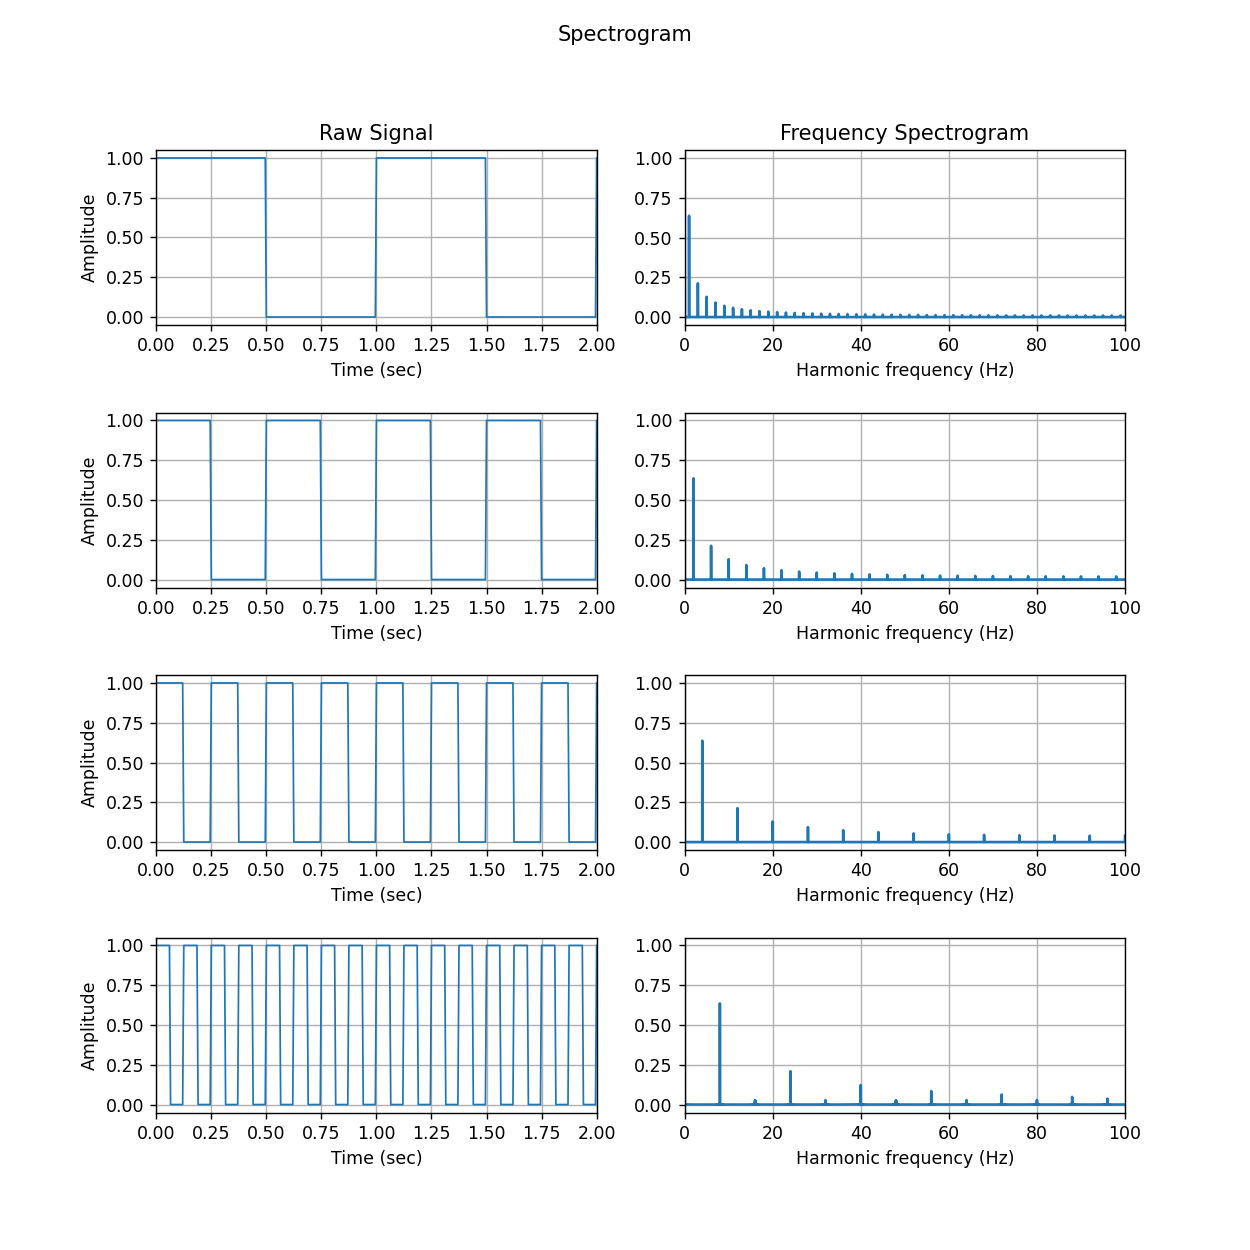

In [76]:
# Creation of figure and subplots
fig, ((afunc1, aspec1), (afunc2, aspec2), (afunc4, aspec4), (afunc8, aspec8)) = plt.subplots(figsize=(10, 10), dpi=100, nrows=4, ncols=2)
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Spectrogram')
signals   = fig.axes[::2]
spectrums = fig.axes[1::2]

# Setting visible intervals
xlim(signals, [(0, 2)])
xlim(spectrums, [(0, 100)])

# Drawing grid
grid(signals)
grid(spectrums)

# Setting y labels
ylabel(signals, 'Amplitude')

# Setting x labels
xlabel(signals, 'Time (sec)')
xlabel(spectrums, 'Harmonic frequency (Hz)')

# Setting column titles
afunc1.set_title('Raw Signal')
aspec1.set_title('Frequency Spectrogram')

style = '-'

# Plotting
afunc1.plot(xf1, yf1, style, lw=1)
afunc2.plot(xf2, yf2, style, lw=1)
afunc4.plot(xf4, yf4, style, lw=1)
afunc8.plot(xf8, yf8, style, lw=1)

aspec1.plot(xs1, ys1, style)
aspec2.plot(xs2, ys2, style)
aspec4.plot(xs4, ys4, style)
aspec8.plot(xs8, ys8, style)